# Allocation of Demand based on Disaggregation and Re-aggregation of Data

This notebook is used to disaggregate demand from the FERC-714 dataset, based on the population from census data, then re-aggregating it to different various geometries like REEDs balancing areas, county-level, or at the state level.

## Datasets and inputs used

1. FERC-714 form: Energy sales timeseries data for every planning area

2. 2010 US Census data: Census tract geometries, and tract-level population and characteristics

3. ReEDs balancing geometries: ReEDs geometries containing county level data

4. US Planning Areas: Contains 97 planning area geometries

## Core functions

1. Function to find intersection of the large and small geometries

2. Function to normalize and redistribute from area to another attribute e.g. population

3. Map functions:

4. Timeseries functions: Functions for allocation

## Disposable parts of analysis

1. Cells doing auxiliary analysis like multiple-counted areas, visualizations for state, county and census tracts 

## Intermediate and Final Datasets

Intermediate datasets are required to limit the number of time-consuming calculations. Primarily, the overlay calculation takes excessive time.

### Intermediate Datasets

Area mapping of planning area with census tracts.

### Final Datasets

ReEDs aggregated demand timeseries data

## Workflow

1. There are generally two geometries: one containing primary smaller non-intersecting geometries like tracts, and the other with larger intersecting geometries

### Disaggregation of data




### Reaggregation of data




In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime 

import pyproj
import matplotlib.cm as cm
from matplotlib import colors
from geopandas import gpd
from shapely.geometry import Point
from matplotlib.legend import Legend
import sys
import os
import geopandas
import fiona
import matplotlib.patches as mpatches
from geopandas import GeoDataFrame
import seaborn as sns
import pickle

from tqdm import tqdm
tqdm.pandas()
import pathlib
import scipy.stats

/home/yashkumar/anaconda3/envs/geo_env_2/lib/python3.8/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import sys

src_path = pathlib.Path.cwd().parent / 'src'
data_path = pathlib.Path.cwd().parent / 'data'

sys.path.append(str(src_path))

from agg_disagg_shape_params import *

In [3]:
## Importing US census tract data
gdf = gpd.read_file(str(data_path / "USA_Census_Tract_Boundaries/v10/tracts.gdb"),
                    driver='FileGDB', layer='tracts')

gdf["STATE_FIPS"] = pd.to_numeric(gdf["STATE_FIPS"])

## Removing all islands and non-mainland states and territories
gdf = gdf[(gdf["STATE_FIPS"] <= 56) &
          (gdf["STATE_FIPS"] != 44) &
          (gdf["STATE_FIPS"] != 15) &
          (gdf["STATE_FIPS"] != 2)]

## Projecting to US Albers conic equal-area projection
gdf = gdf.to_crs("ESRI:102003")

In [4]:
## Importing US planning areas
gdf_planning_areas = gpd.read_file(str(data_path / "DHS/Electric_Planning_Areas.gdb"),
                                   driver='FileGDB', layer='Planning_Areas')

## Dropping islands and non-mainland states and territories
gdf_planning_areas = gdf_planning_areas.drop([92, 68])
gdf_planning_areas["ID"] = pd.to_numeric(gdf_planning_areas["ID"])

## Projecting to US Albers conic equal-area projection
gdf_planning_areas = gdf_planning_areas.to_crs("ESRI:102003")

## Importing demand timeseries data
ferc_df = pd.read_csv(str(data_path / "FERC/form714-database/planning_area_hourly_demand_ferc714.csv"),
                      parse_dates=["local_time"])

ferc_df["eia_code"] = pd.to_numeric(ferc_df["eia_code"])

## IDs different for the areas, needed to be renamed
ferc_df.loc[ferc_df["eia_code"]==229, "eia_code"] = 2775
ferc_df.loc[ferc_df["eia_code"]==17690, "eia_code"] = 59504
ferc_df.loc[ferc_df["respondent_name"]=="PacifiCorp - Part II Sch 2 (East & West combined)", "eia_code"] = 14379
ferc_df.loc[ferc_df["respondent_name"]=="East Texas Electric Cooperative", "eia_code"] = 18679

## merging 2018 demand data with gdf_planning_areas
ferc_demand_sum = (ferc_df[(ferc_df["local_time"]>="2018-01-01") &
                           (ferc_df["local_time"]<"2019-01-01")]
                   .groupby("eia_code")[["demand_mwh"]]
                   .sum()
                   .reset_index())

ferc_demand_sum = ferc_demand_sum.rename(columns={"demand_mwh": "demand_mwh_2018"})

gdf_planning_areas = (gdf_planning_areas
                      .merge(ferc_demand_sum, how="inner", left_on="ID", right_on="eia_code")
                      .drop("eia_code", axis=1))

In [5]:
if sum(["tracts_planning_area_ratios_stacked.pkl" in str(a) for a in data_path.glob("*")]):

    with open(str(data_path / "tracts_planning_area_ratios_stacked.pkl"), "rb") as f:
        gdf_intersection = pickle.load(f)
    
else:
    gdf_intersection = create_save_stacked_intersection_df(gdf, gdf_planning_areas)

In [6]:
intersection_matrix = create_intersection_matrix(gdf_intersection)
pop_norm_matrix = matrix_linear_scaling(intersection_matrix, gdf_scale=gdf)
demand_norm_matrix = matrix_linear_scaling(pop_norm_matrix, gdf_scale=gdf_planning_areas,
                                          gdf_scale_col="demand_mwh_2018", axis_scale=0)

In [7]:
gdf = gdf.merge(demand_norm_matrix
          .sum(axis=1)
          .reset_index()
          .rename(columns={0: "demand_mwh_2018"}))

## Created tracts demand aggregated by state
county_gdf = gdf[["STCOFIPS", "geometry"]].merge(gdf
                                                 .groupby("STCOFIPS")[["demand_mwh_2018", "SQMI", "POPULATION"]]
                                                 .sum()
                                                 .reset_index())

county_gdf["energy_demand_per_sqmi"] = county_gdf["demand_mwh_2018"] / county_gdf["SQMI"]
county_gdf["demand_per_capita"] = county_gdf["demand_mwh_2018"] / county_gdf["POPULATION"]

## Created tracts demand aggregated by state
state_gdf = gdf[["STATE_FIPS", "geometry"]].merge(gdf
                                                  .groupby("STATE_FIPS")[["demand_mwh_2018", "SQMI", "POPULATION"]]
                                                  .sum()
                                                  .reset_index())

state_gdf["energy_demand_per_sqmi"] = state_gdf["demand_mwh_2018"] / state_gdf["SQMI"]

state_gdf["demand_per_capita"] = state_gdf["demand_mwh_2018"] / state_gdf["POPULATION"]

In [8]:
sales_df = pd.read_excel(str(data_path / "EIA/sales_annual.xlsx"), skiprows=[0])
sales_df = sales_df[sales_df["Year"]==2018]
sales_df = sales_df[~sales_df["State"].isin(["US", "HI", "AK", "DC"])]
print(sales_df["Industry Sector Category"].unique())
sales_df = sales_df[sales_df["Industry Sector Category"]=="Total Electric Industry"]

states_fips_lookup = pd.read_html("https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696")[0].iloc[:-1]
states_fips_lookup = states_fips_lookup.astype({
    "FIPS": "int32"
})

# states_fips_lookup["FIPS"] = states_fips_lookup["FIPS"].apply(lambda x: int(x))

sales_df = sales_df.merge(states_fips_lookup, left_on="State",
                          right_on="Postal Code")[["State", "Total", "FIPS",
                                                   "Residential", "Commercial", "Industrial"]]

sales_df = (state_gdf[["STATE_FIPS", "demand_mwh_2018"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .merge(sales_df, left_on="STATE_FIPS", right_on="FIPS")).drop("FIPS", axis=1)

sales_df = sales_df.sort_values("demand_mwh_2018", ascending=False).reset_index(drop=True)

sales_df["pc_error"] = abs(sales_df["Total"] - sales_df["demand_mwh_2018"]) / sales_df["Total"]


sales_df = sales_df.sort_values("pc_error", ascending=False).reset_index(drop=True)
sales_sum = sales_df["Total"].sum()
allocated_demand_sum = sales_df["demand_mwh_2018"].sum()

sales_df["adjusted_demand"] = sales_df["demand_mwh_2018"] * sales_sum / allocated_demand_sum

sales_df.head()

['Total Electric Industry' 'Full-Service Providers'
 'Energy-Only Providers']


,STATE_FIPS,demand_mwh_2018,State,Total,Residential,Commercial,Industrial,pc_error,adjusted_demand
0,31,5.442649e+07,NE,30939492,10412008,9553396,10974088,0.759127,4.892275e+07
1,46,2.134579e+07,SD,12856938,5018360,4903243,2935335,0.660255,1.918725e+07
2,20,6.637959e+07,KS,42036979,14187192,16168750,11681037,0.579076,5.966713e+07
3,30,2.266471e+07,MT,14838845,5197686,4921231,4719928,0.527391,2.037280e+07
4,34,1.153194e+08,NJ,76016762,29530689,38807065,7369106,0.517027,1.036581e+08


In [9]:
## Areas in demand dataframe that do not have a shape geometry

(ferc_demand_sum[~ferc_demand_sum["eia_code"].isin(pop_norm_matrix.columns)]
 .merge(ferc_df[["eia_code", "respondent_name"]])
 .drop_duplicates())

,eia_code,demand_mwh_2018,respondent_name
0,3522.0,1258622.00,"Chugach Electric Association, Inc."
113953,13100.0,11132980.00,Municipal Electric Authority of Georgia
157777,17867.0,807656.00,City of St. Cloud
271731,19547.0,7002252.63,"Hawaiian Electric Company, Inc"


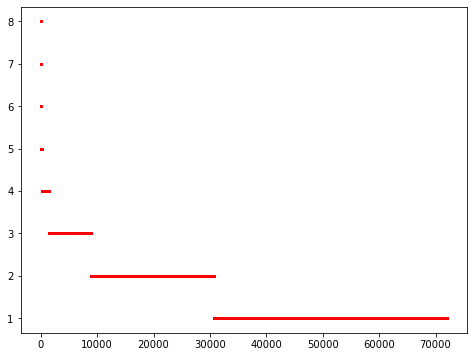

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot((intersection_matrix != 0)
         .sum(axis=1)
         .sort_values(ascending=False)
         .tolist(), 'ro', ms=2)

plt.show()

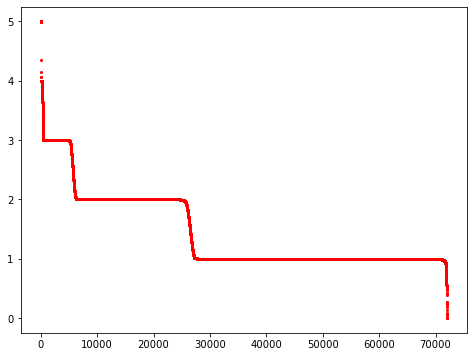

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(create_intersection_matrix(gdf_intersection, normalization=0)
         .sum(axis=1)
         .sort_values(ascending=False)
         .tolist(), 'ro', ms=2)

plt.show()

<ipython-input-16-96e2797ff2fb>:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


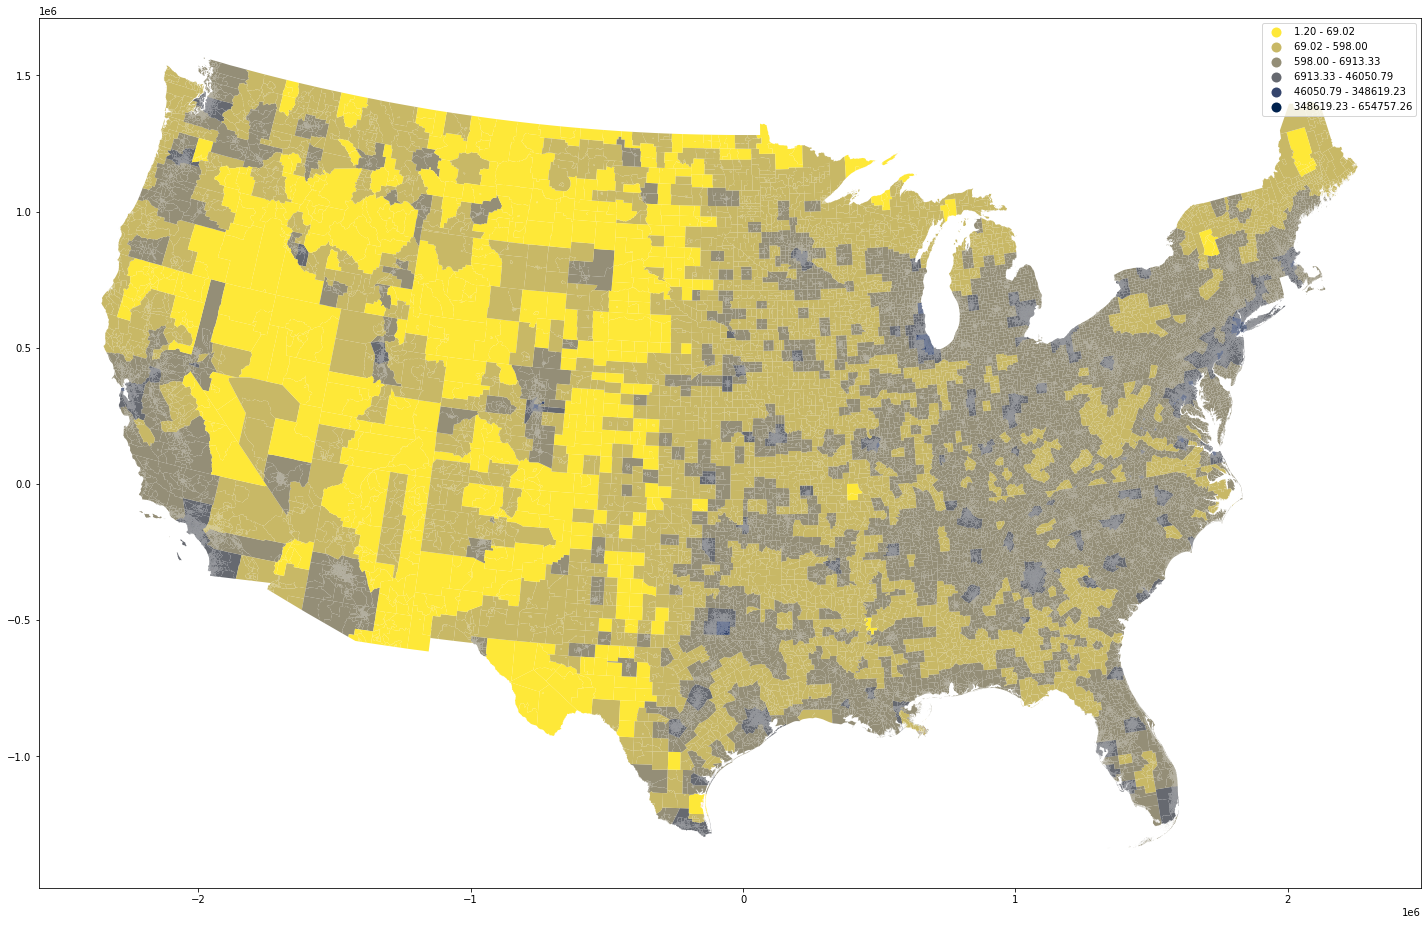

In [16]:
## County demand per unit area
fig, ax = plt.subplots(figsize=(28, 16))
county_gdf.plot(column="energy_demand_per_sqmi", cmap="cividis_r", ax=ax,
                          legend=True, scheme="percentiles")
plt.show()

<ipython-input-13-6da82581710e>:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


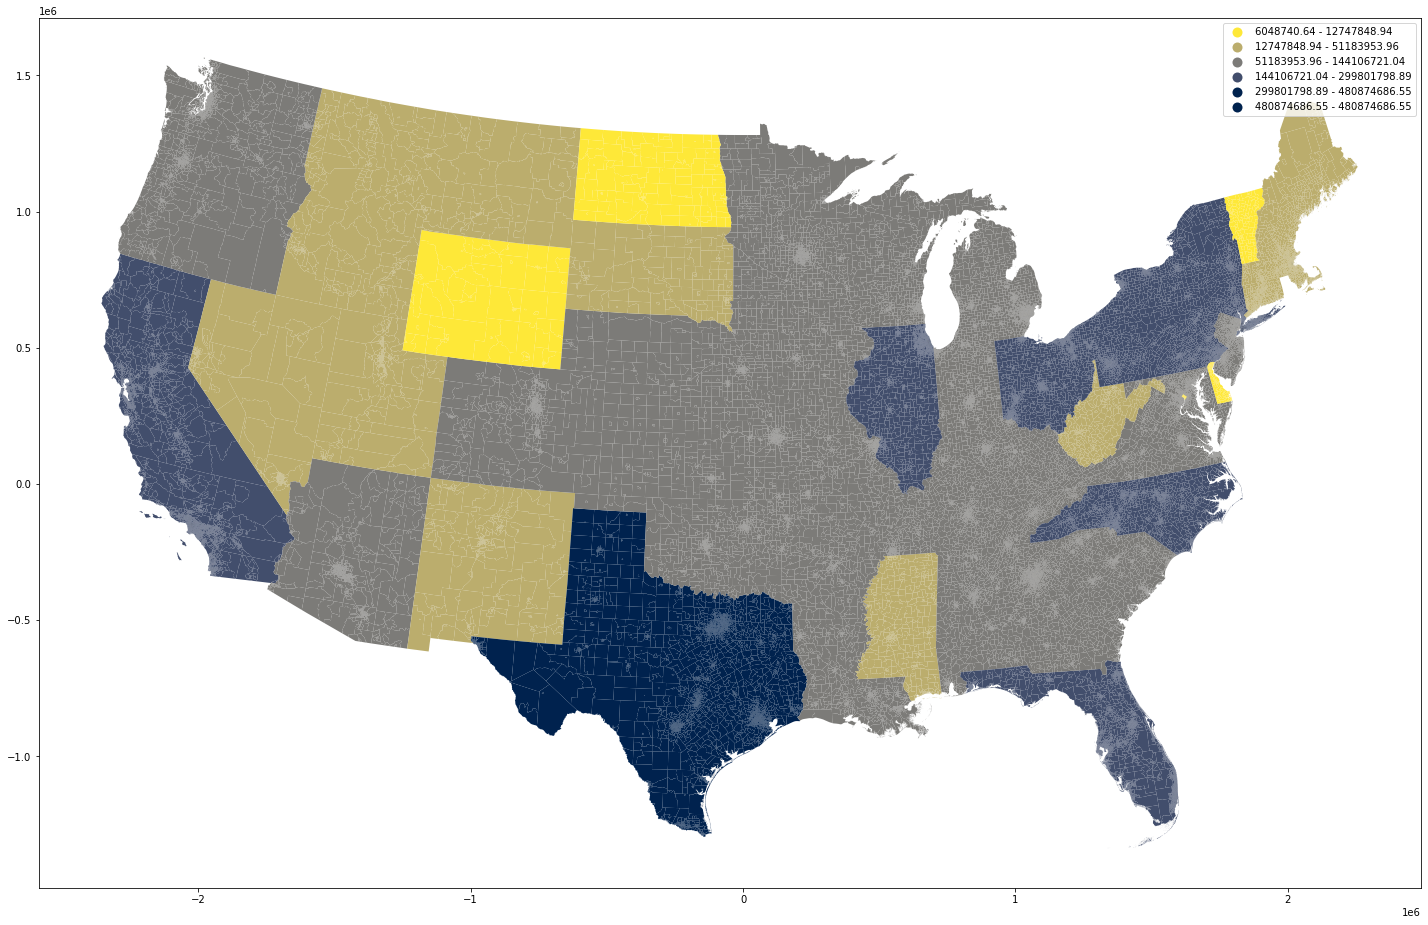

In [13]:
## State demand figure
fig, ax = plt.subplots(figsize=(28, 16))
state_gdf.plot(column="demand_mwh_2018", cmap="cividis_r", ax=ax, legend=True, scheme="percentiles")
plt.show()

<ipython-input-14-a832004c5888>:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


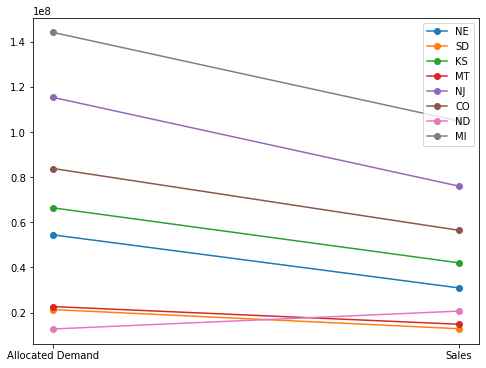

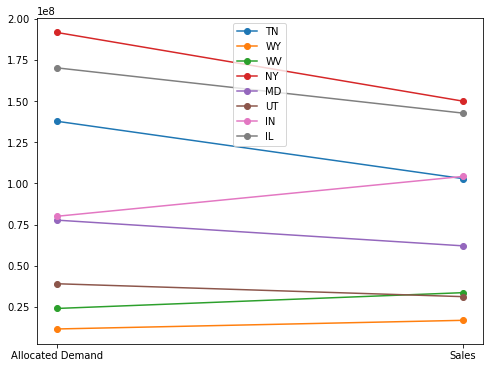

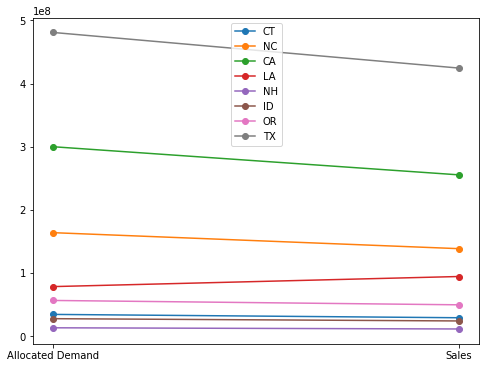

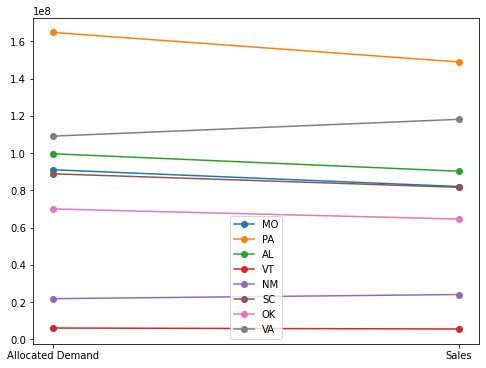

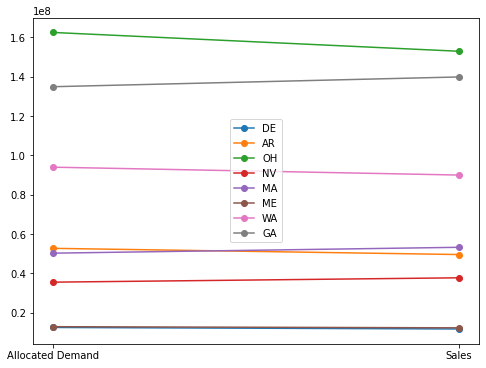

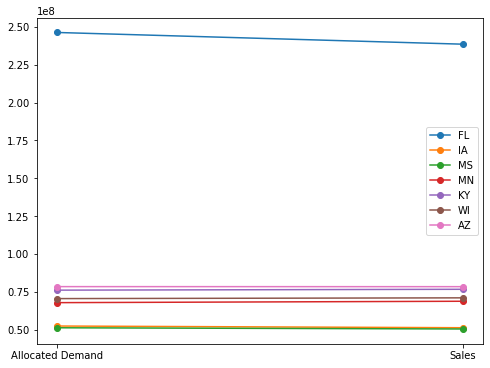

In [14]:
# 6 figures of 8 states with allocated demand and FERC sales

for i in range(6):

    fig, ax = plt.subplots(figsize=(8, 6))

    for idx, row in sales_df.iloc[8*i: 8*(i+1)].iterrows():

        ax.plot([row["demand_mwh_2018"], row["Total"]], marker="o", label=row["State"])
        
    plt.xticks([0, 1], ["Allocated Demand", "Sales"])
    plt.legend()    
    plt.show()
    

<ipython-input-15-e4cbd2d27dc8>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


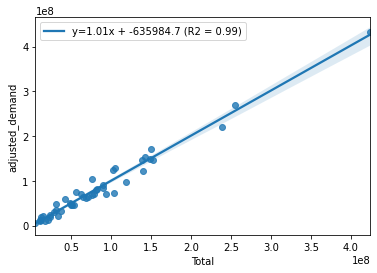

In [15]:
pred = 'adjusted_demand'
actual = "Total"



def r2(x, y):
    
    return scipy.stats.pearsonr(sales_df[actual], sales_df[pred])


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sales_df[actual], sales_df[pred])

ax = sns.regplot(x=actual, y=pred, data=sales_df, line_kws={'label':"y={0:.2f}x + {1:.1f} (R2 = {2:.2f})".format(slope,intercept,r_value)})

# ax = sns.jointplot(x="Residential", y="Demand", data=sales_df, stats_func=r2)


ax.legend()
plt.show()